# LMF - SCPF Comparison on Swimmer Data 
This notebook presents experiment results on swimmer data. The aim is to show our model generates sensible outputs.

We first present the data, and then compare Logistic Matrix Factorization (LMF) and Sum Conditioned Poisson Factorization (SCPF).

1. Data
2. Non-missing Data Experiments
    

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import numpy as np
from numpy.linalg import matrix_rank

import collections
import pandas as pd

import sys
sys.path.append('../src/')      

from Utils import *
from SumConditionedPF import em_scpf

def get_subset(data, num_samples):
    
    I,J,K = data.shape    
    feat_len = I*J

    subdata = np.zeros((feat_len, num_samples), dtype=float)
    sample_indices = np.random.randint(0, K, num_samples)
    j=0
    for i in sample_indices:
        subdata[:,j] = np.reshape(data[:,:,i], feat_len)
        j += 1

    return subdata

## 1. Data
swimmer dataset: 256 images of size 32x32

Source: http://web.stanford.edu/~vcs/Papers.html (at the end of the page)

### Prepare Data

In [2]:
data_path = '../data/'
data_file = 'Y.mat'

data = sio.loadmat(data_path + data_file)
Y = data['Y']

# Binarize
Y_bin = np.copy(Y)
Y_bin[np.where(Y==39)] = 1
Y_bin[np.where(Y==1)] = 0

In [3]:
J = 256 # num of samples
X = get_subset(Y_bin, J)
I = X.shape[0]

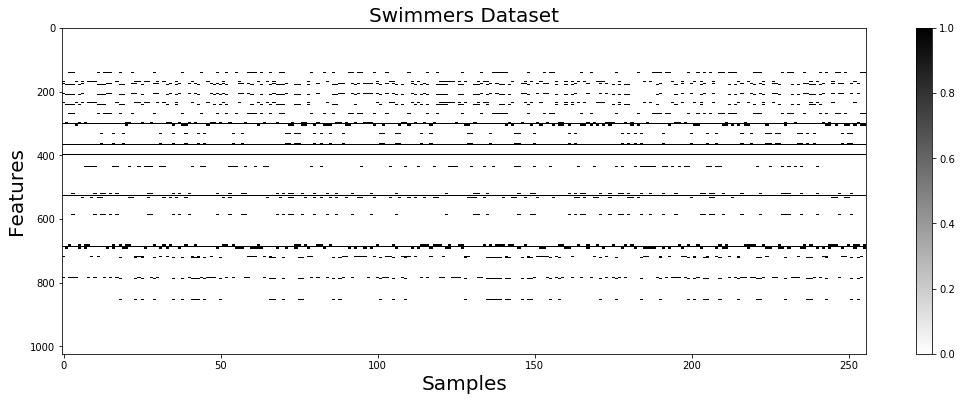

In [4]:
plot_matrix(X, title='Swimmers Dataset', xlabel='Samples', ylabel='Features')        

## 2. Non-missing Data Experiments

In [5]:
print('rank of matrix via SVD =', matrix_rank(X))

rmse = collections.OrderedDict()

rank of matrix via SVD = 13


### Logistic MF Benchmark

In [6]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

def LogisticMF(Y, K, Mask):
    M, N = Y.shape
    
    # Implement Gradient Descent
    W = np.random.randn(M,K)
    H = np.random.randn(K,N)

    #H = H_true

    eta = 0.005
    nu = 0.1

    MAX_ITER = 5000
    for epoch in range(MAX_ITER):
        dL = np.dot(W.T, Mask*(Y-sigmoid(np.dot(W,H)))  ) - nu*H
        H = H + eta*dL
        dL = np.dot(Mask*(Y-sigmoid(np.dot(W,H))),H.T ) - nu*W
        W = W + eta*dL

        if epoch % 100 == 0:
            LL = np.sum(Mask*(Y*np.log(sigmoid(np.dot(W,H))) +  (1-Y)*np.log(1 - sigmoid(np.dot(W,H))))) - nu*np.sum(H**2)/2. - nu*np.sum(W**2)/2. 
            LL_test = np.sum((1-Mask)*(Y*np.log(sigmoid(np.dot(W,H))) +  (1-Y)*np.log(1 - sigmoid(np.dot(W,H)))))  
            print(epoch, LL, LL_test)
        

    return W,H

Y = X.copy()
M, N = Y.shape
K = 15
p_miss = 0.
Mask = np.array(p_miss<np.random.rand(M,N),dtype=float)

W, H = LogisticMF(Y, K, Mask)
X_hat = sigmoid(np.dot(W,H))
rmse['lmf'] = np.sqrt(np.mean((Y-X_hat)**2))

0 -265694.17065876315 0.0
100 -1629.7945315541547 0.0
200 -1374.2272356440112 0.0
300 -1291.2801638388605 0.0
400 -1231.0893023456697 0.0
500 -1179.9032953249662 0.0
600 -1134.7446300780848 0.0
700 -1094.5150230927989 0.0
800 -1058.5865876256748 0.0
900 -1026.4901121046696 0.0
1000 -997.8298799439169 0.0
1100 -972.2556689454037 0.0
1200 -949.4517794727425 0.0
1300 -929.1320018877327 0.0
1400 -911.0368682288423 0.0
1500 -894.9317398773221 0.0
1600 -880.6051097805048 0.0
1700 -867.8668849726986 0.0
1800 -856.5466068661208 0.0
1900 -846.4916495793891 0.0
2000 -837.5654587982891 0.0
2100 -829.6458864250156 0.0
2200 -822.6236580641079 0.0
2300 -816.4009910717725 0.0
2400 -810.8903650869352 0.0
2500 -806.013436239273 0.0
2600 -801.7000803990438 0.0
2700 -797.8875488194601 0.0
2800 -794.5197200040977 0.0
2900 -791.5464334418893 0.0
3000 -788.9228931452014 0.0
3100 -786.6091311871612 0.0
3200 -784.56952340679 0.0
3300 -782.7723510489436 0.0
3400 -781.1894033399747 0.0
3500 -779.7956169220603 0

In [7]:
print(rmse['lmf'])

0.0007053641047675768


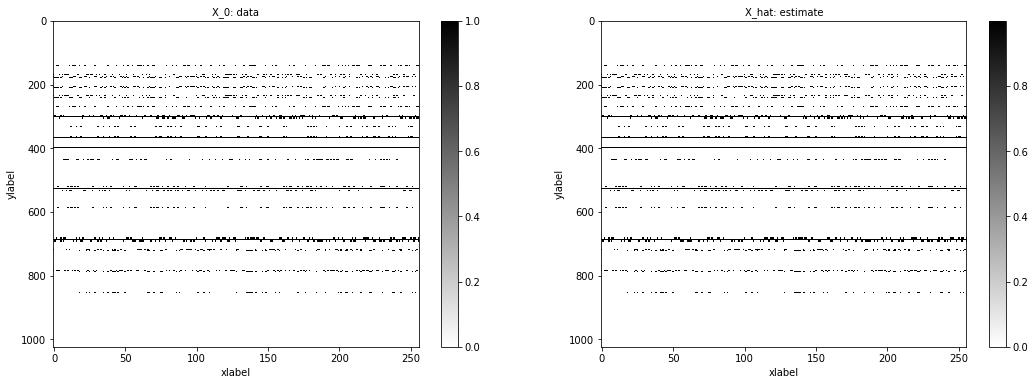

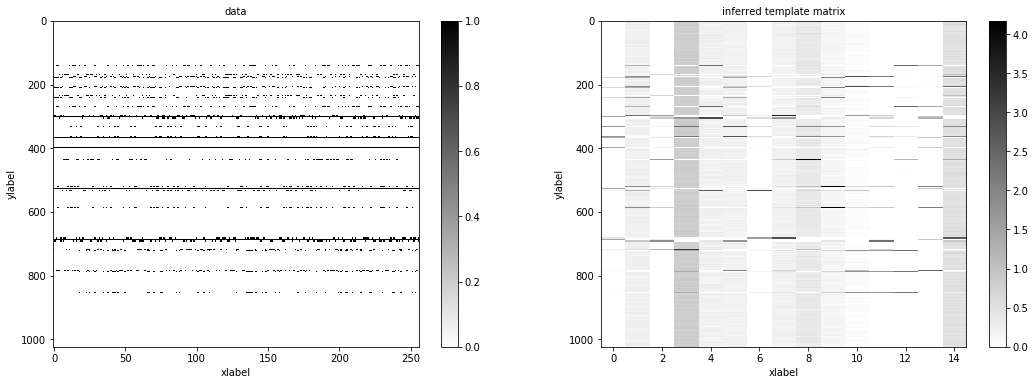

In [8]:
plot_matrices(Y, X_hat, title1='X_0: data',title2='X_hat: estimate') 
plot_matrices(Y, W, title1='data', title2='inferred template matrix')

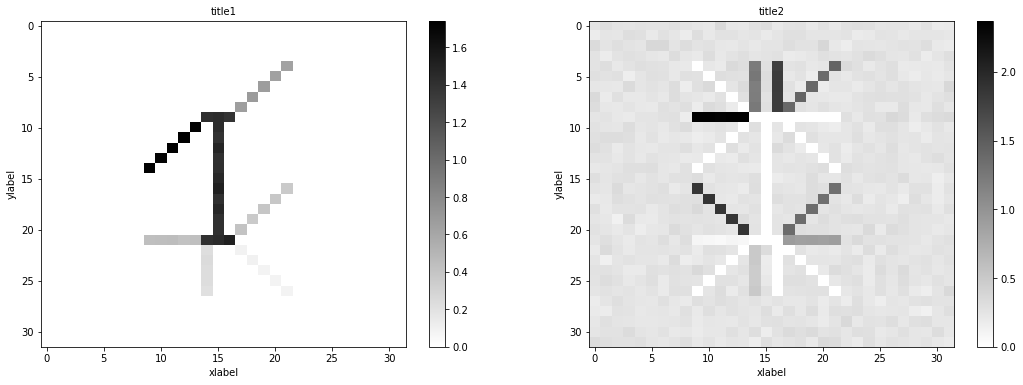

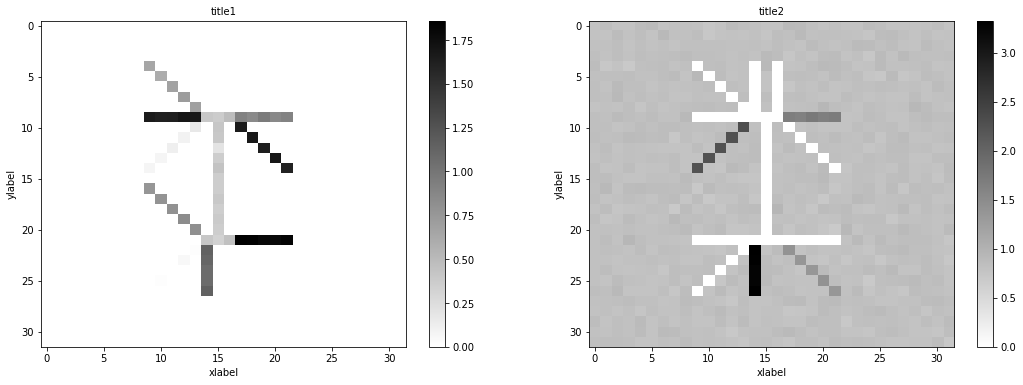

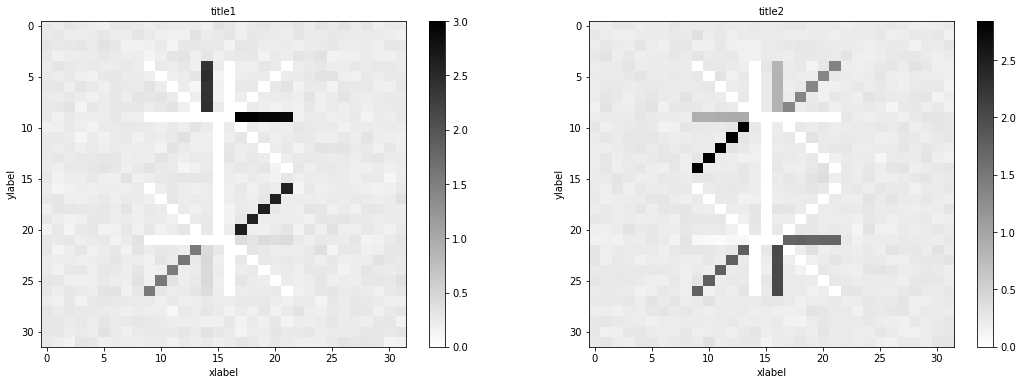

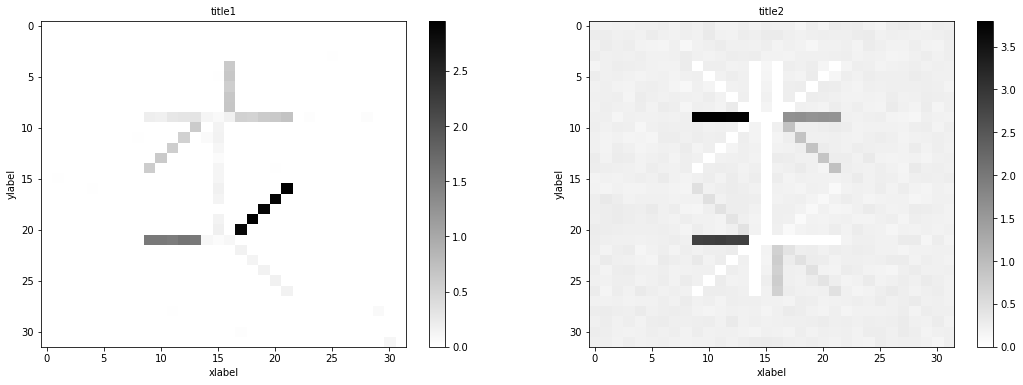

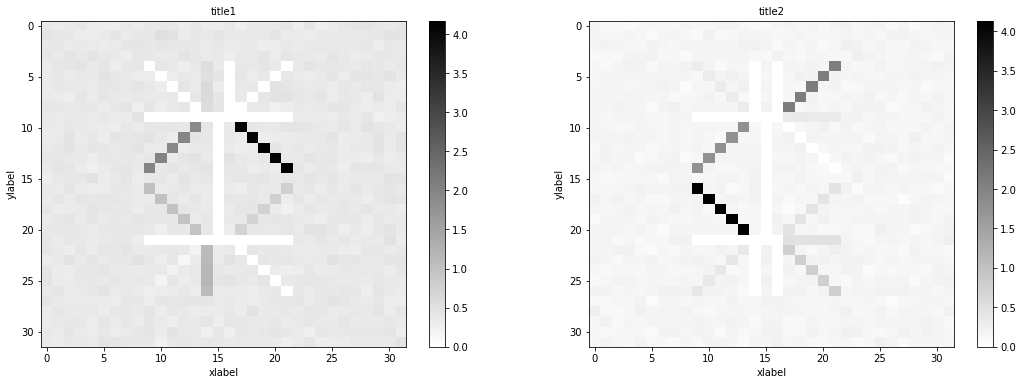

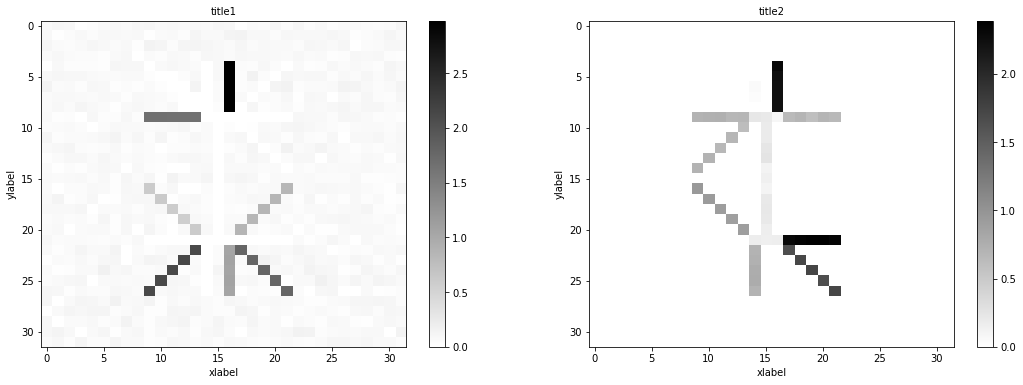

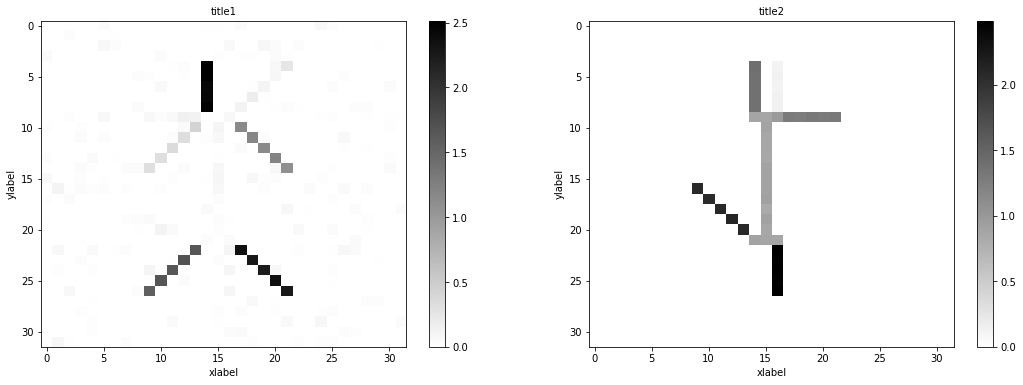

In [9]:
for i in range(0,14,2):
    n_w0 = W[:,i]
    n_w1 = W[:,i+1]
    plot_matrices(n_w0.reshape(32,32), n_w1.reshape(32,32))

### SCPF 

In [5]:
print('rank of matrix via SVD =', matrix_rank(X))

rank of matrix via SVD = 13


### Without Mask

In [5]:
MAX_ITER = 300
PRINT_PERIOD = 1

# num of decompositions
K = 2 
I, J = X.shape

# rank
N = 15 
N_max = 1. * np.ones((I,J))

X_new = np.zeros((K, I, J))
X_new[0] = X.copy()
X_new[1] = 1-X_new[0]

Mask = np.ones((K, I, J))
Mask_nan = Mask.copy()
Mask_nan[Mask==0] = np.nan

In [6]:
a = 10.
b = .4
W = np.random.gamma(a, b/a, (K, I, N))
H = np.random.gamma(a, b/a, (K, N, J))

W, H, logP = em_scpf(N_max, X_new, Mask, W, H, A=0.001, MAX_ITER=MAX_ITER, PRINT_PERIOD=PRINT_PERIOD)
X_hat = np.array([np.dot(W[k], H[k]) for k in range(K)])

A =  0.001 
B =  0.2581988897471611
0 -23091.766046166133
1 -22992.016098914464
2 -22918.13971651325
3 -22774.135066116043
4 -22480.88511801787
5 -21889.05527672958
6 -20770.25355722741
7 -18959.19825681739
8 -16695.1792573828
9 -14555.709776883017
10 -12867.414543656174
11 -11605.217262582615
12 -10650.477367530682
13 -9924.769666032493
14 -9389.403650190683
15 -9010.246560636708
16 -8748.734074296346
17 -8571.654079359549
18 -8457.081916308953
19 -8383.82021763006
20 -8335.012141775927
21 -8300.661476916515
22 -8275.180096145172
23 -8255.206027454878
24 -8238.466034380168
25 -8223.219547408287
26 -8207.943795964226
27 -8191.256943208299
28 -8172.455335449218
29 -8152.6781021747165
30 -8134.410487896529
31 -8118.75207548664
32 -8104.91735250752
33 -8091.7164313548465
34 -8078.312558963459
35 -8064.228230935593
36 -8049.191886945469
37 -8033.027870624614
38 -8015.5994288739175
39 -7996.782014467797
40 -7976.450623666675
41 -7954.472812174437
42 -7930.703319320446
43 -7904.978016863692


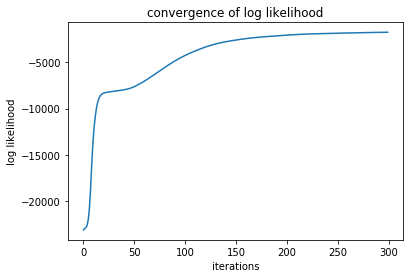

In [7]:
plot_vector(np.array(logP[1:]), title='convergence of log likelihood', xlabel='iterations', ylabel='log likelihood')

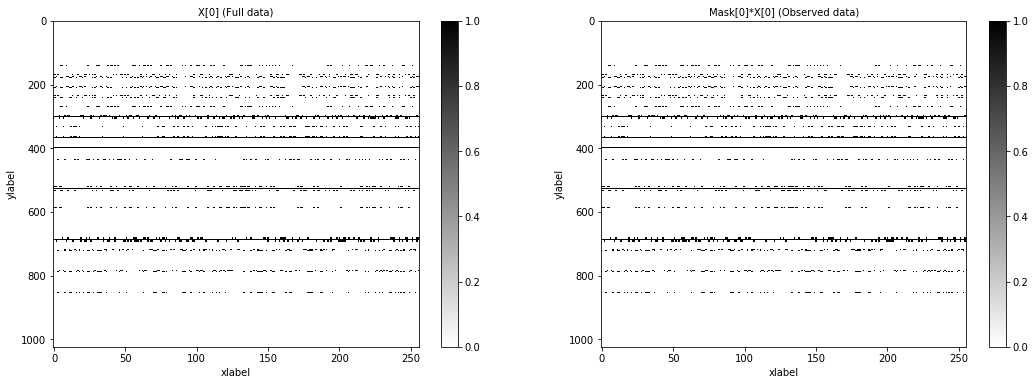

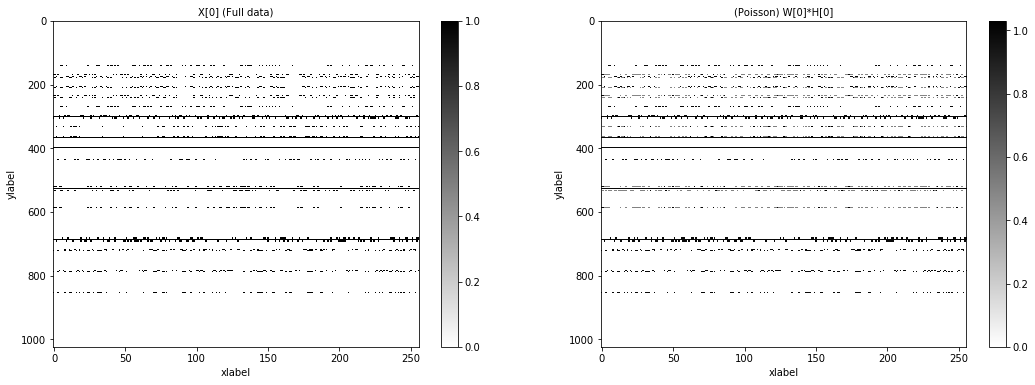

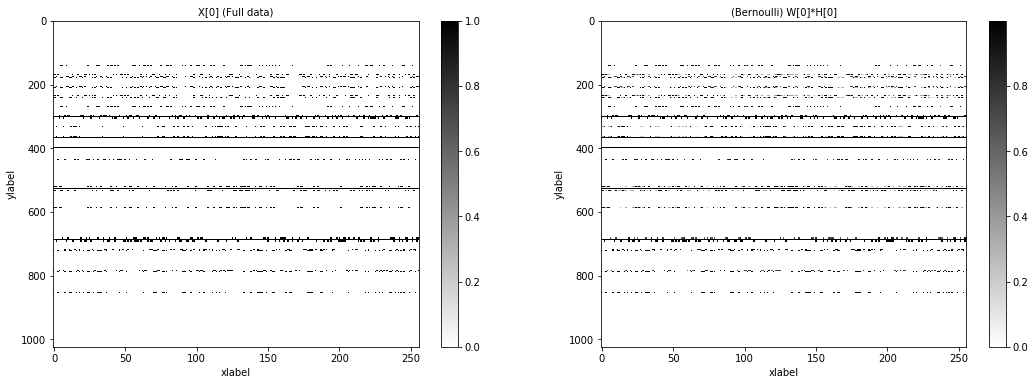

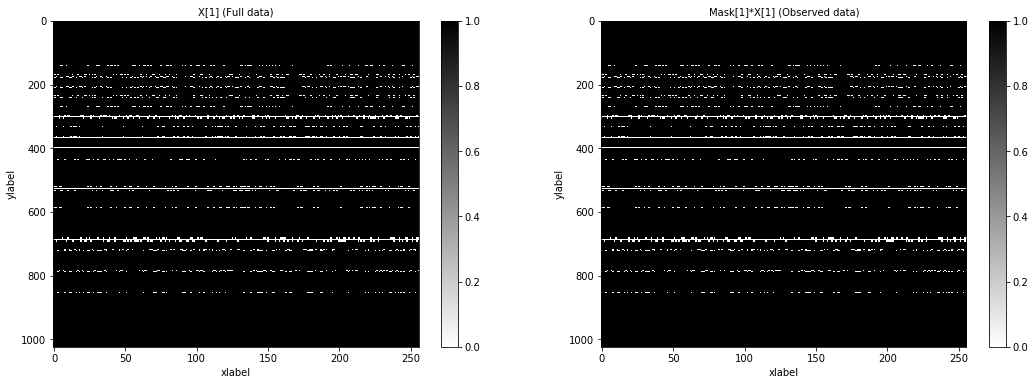

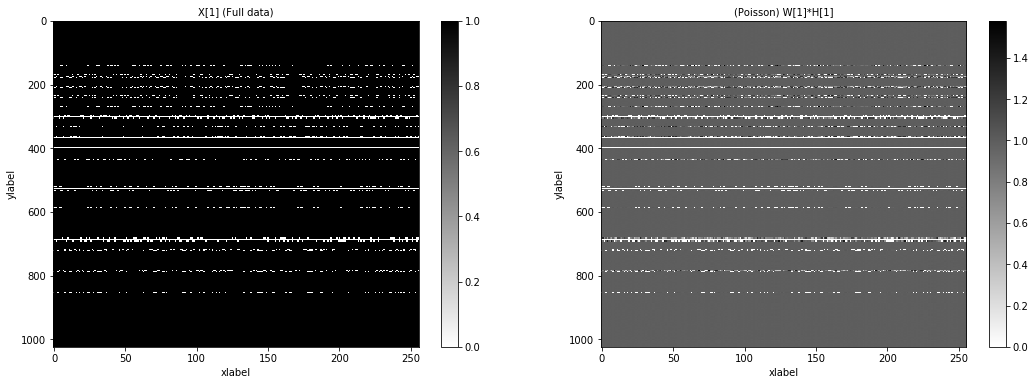

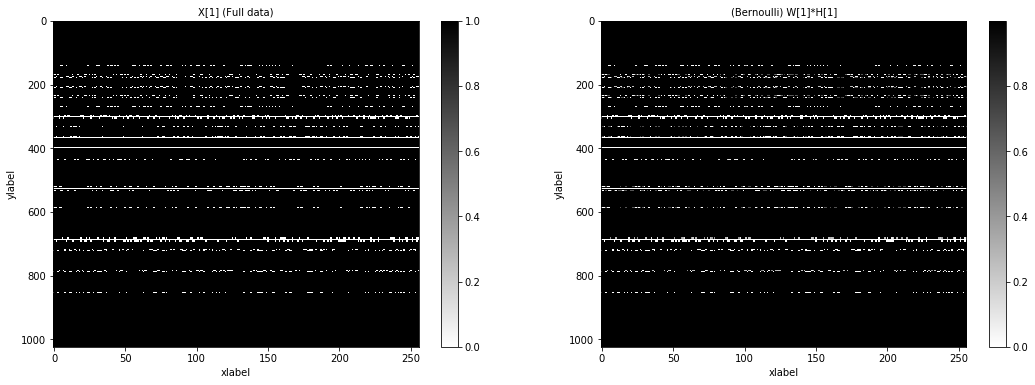

In [8]:
for k in range(K):
    plot_matrices(X_new[k], X_new[k]*Mask_nan[k], title1='X['+ str(k) +'] (Full data)', title2='Mask['+str(k)+']*X['+str(k)+'] (Observed data)')
    plot_matrices(X_new[k], X_hat[k], title1='X['+ str(k) +'] (Full data)', title2='(Poisson) W['+str(k)+']*H['+str(k)+']')
    plot_matrices(X_new[k], X_hat[k]/sum(X_hat), title1='X['+ str(k) +'] (Full data)', title2='(Bernoulli) W['+str(k)+']*H['+str(k)+']')

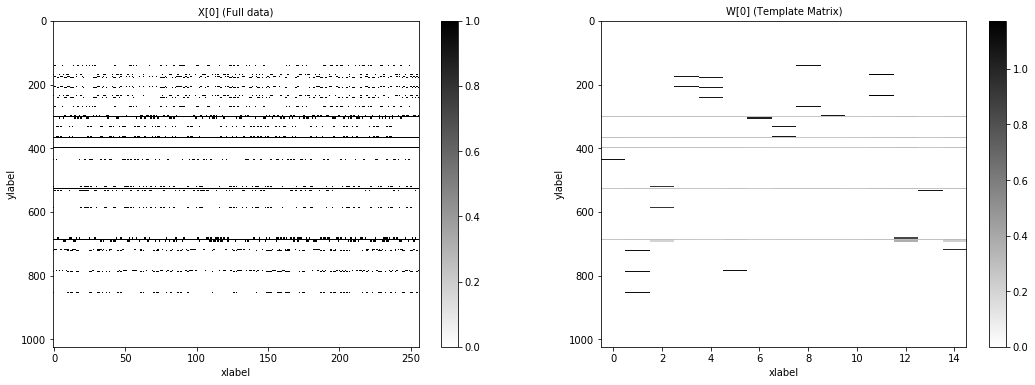

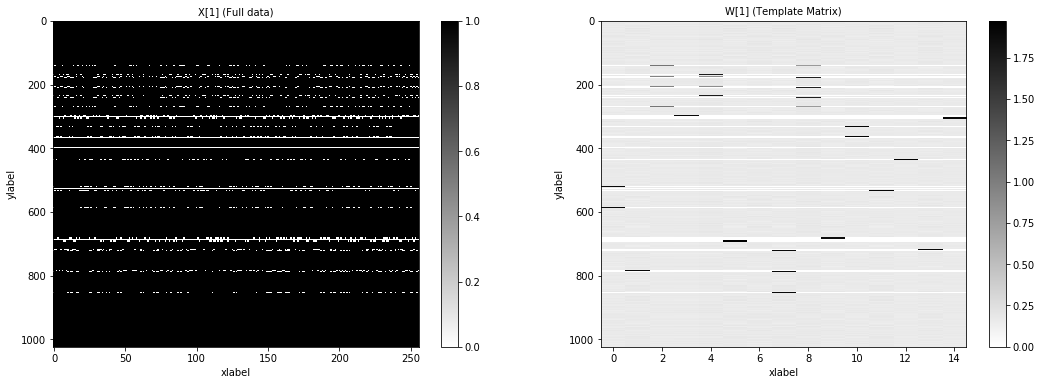

In [13]:
for k in range(K):
    plot_matrices(X_new[k], W[k], title1='X['+ str(k) +'] (Full data)', title2='W['+str(k)+'] (Template Matrix)')

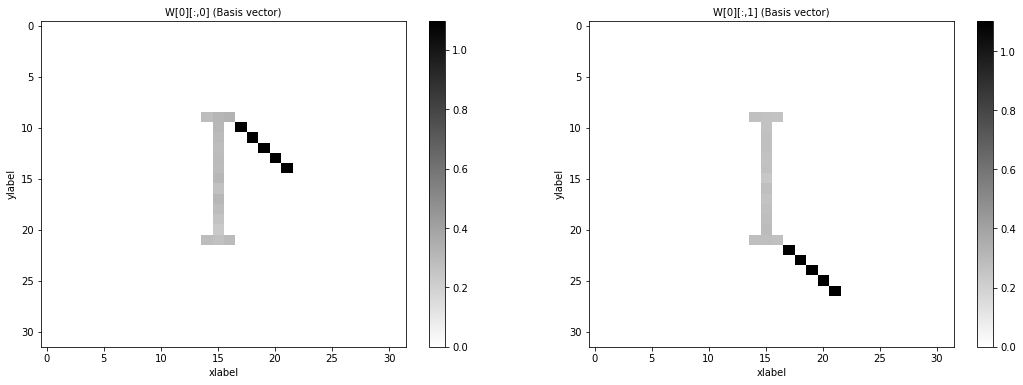

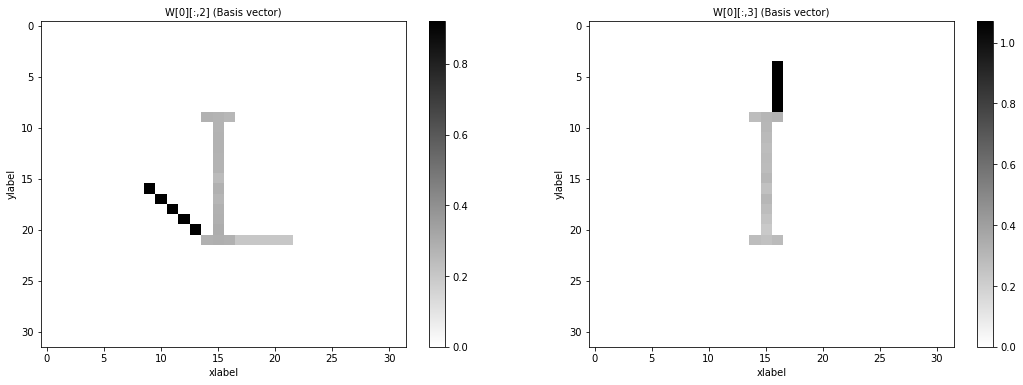

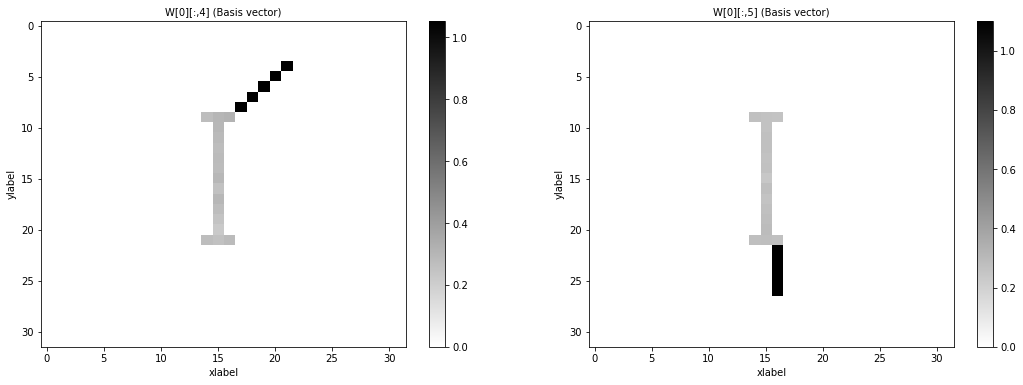

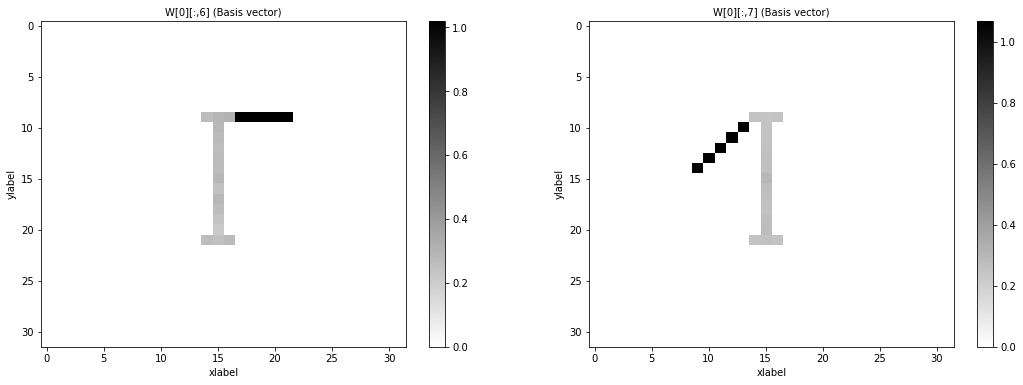

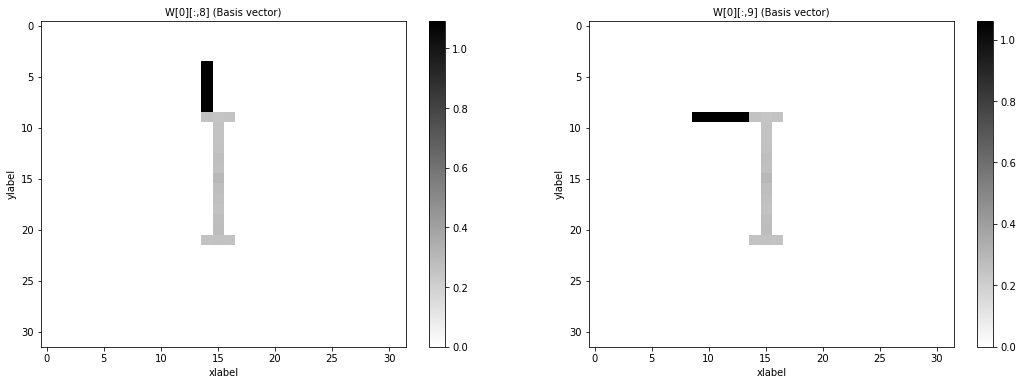

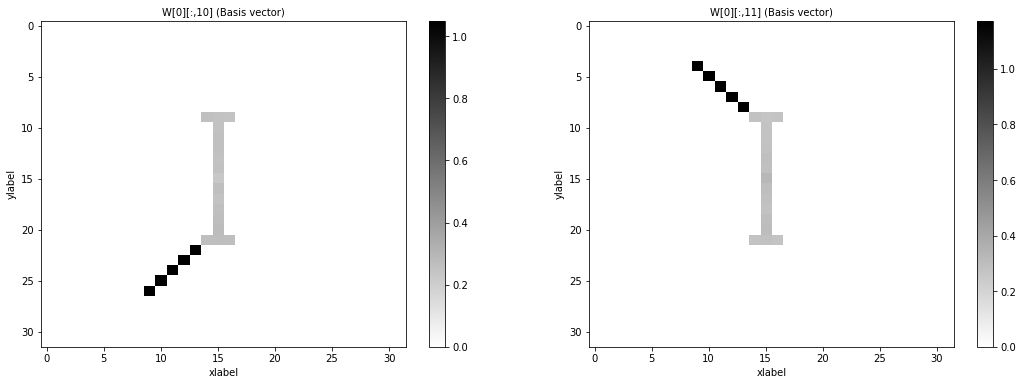

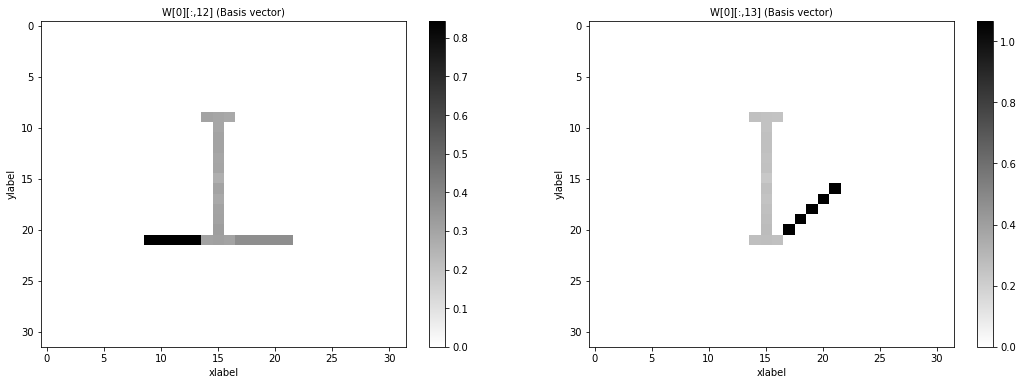

In [14]:
IMAGE_SIZE = (32,32)
for k in range(0,14,2):
    n_w0 = W[0,:,k]
    n_w1 = W[0,:,k+1]
    plot_matrices(n_w0.reshape(IMAGE_SIZE), n_w1.reshape(IMAGE_SIZE), title1='W[0][:,'+str(k)+'] (Basis vector)', title2='W[0][:,'+str(k+1)+'] (Basis vector)')